## Packages install

In [1]:
# !pip install -r requirements.txt

# Download weights 
#!mkdir -p models/sam
#!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

#!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/usr/bin/sh: 1: {sys.executable}: not found


## Imports

In [2]:
import pandas as pd
import cv2
import dataclasses
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

%matplotlib inline

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Constants

In [3]:
ROOT_DIR = ''

LABEL_COLUMN = 'Counter'

DEVICE = 'cuda'

SAM_CHECKPOINT = 'model/sam/sam_vit_h_4b8939.pth'
SAM_MODEL_TYPE = 'vit_h'

## Helper functions

In [22]:
@dataclasses.dataclass
class ImageData:
    image: np.ndarray
    labels_df: pd.DataFrame

    def __post_init__(self):
        self.labels_ = sorted(list(self.labels_df[LABEL_COLUMN].unique()))
        for label in self.labels_:
            assert(label in [0, 1, 2, 10])

    def print_stats(self):
        print('labels: ', self.labels_)


    def draw(self):
        plt.figure(figsize=(20,20))
        plt.imshow(self.image)

        for x, y, label in zip(self.labels_df['X'], self.labels_df['Y'], self.labels_df[LABEL_COLUMN]):
            label_to_mark = {
                0: 'b+',
                1: 'r+',
                2: 'g+',
                10: 'w+',
            }
            plt.plot(x, y, label_to_mark[label])

        plt.axis('off')
        plt.show()


def read_multipoint_labels(csv_filepath: str):
    dataframe = pd.read_csv(csv_filepath, header=0, index_col=0)
    image_filepath = ''.join([csv_filepath[:-4], '.tif'])
    image = cv2.imread(image_filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return ImageData(image=image, labels_df=dataframe)

## Training pipeline

In [5]:
sam = sam_model_registry[SAM_MODEL_TYPE](checkpoint=SAM_CHECKPOINT)
sam.to(device=DEVICE)

mask_generator = SamAutomaticMaskGenerator(sam)

In [24]:
image_data = read_multipoint_labels(os.path.join(ROOT_DIR, 'dataset/5uM_biotin_1000x__008.csv'))

## Testing

labels:  [0, 1, 2, 10]


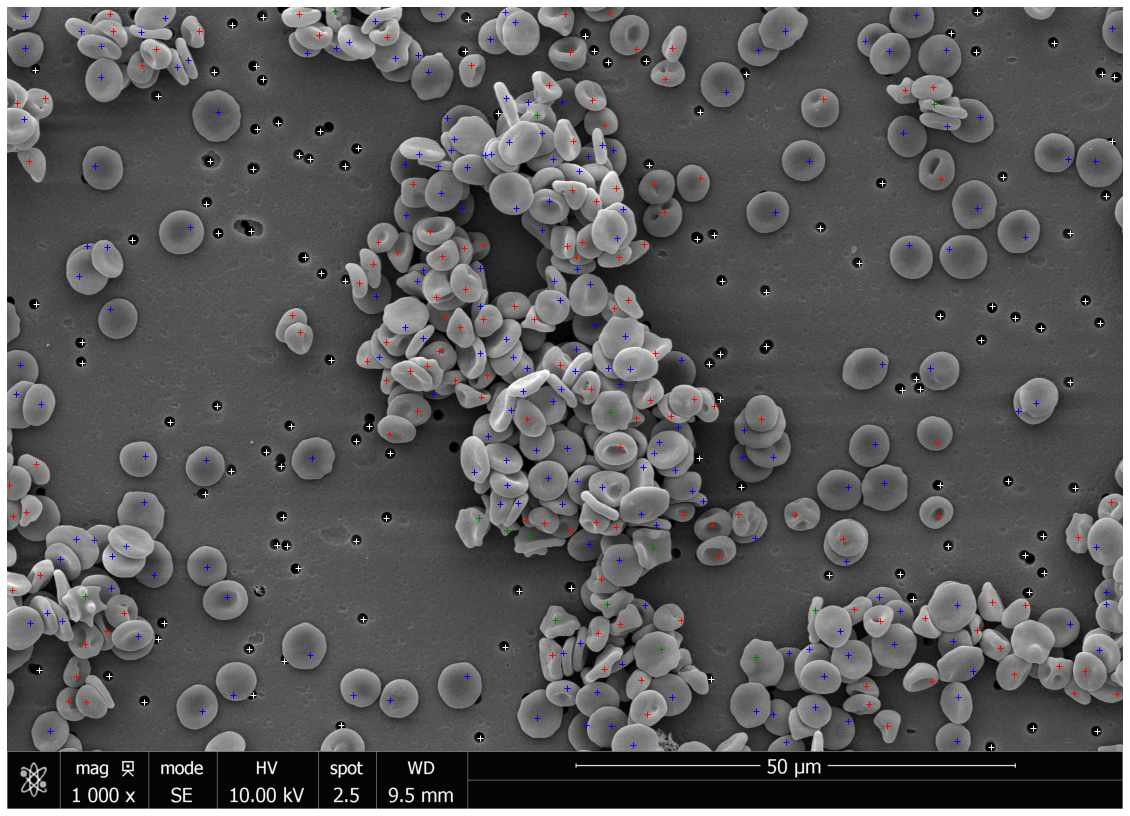

In [28]:
image_data.print_stats()
image_data.draw()

In [9]:
predictor = SamPredictor(sam)
predictor.set_image(image_data.image)

predicted_masks = []
mask_areas = []
for x, y in zip(image_data.labels_df['X'], image_data.labels_df['Y']):
    input_point = np.array([[x, y]])
    input_label = np.array([1])

    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

    best_mask = masks[np.argmax(scores), :, :]
    mask_areas.append(best_mask.sum())
    predicted_masks.append(best_mask)

showing 459 masks out of 459


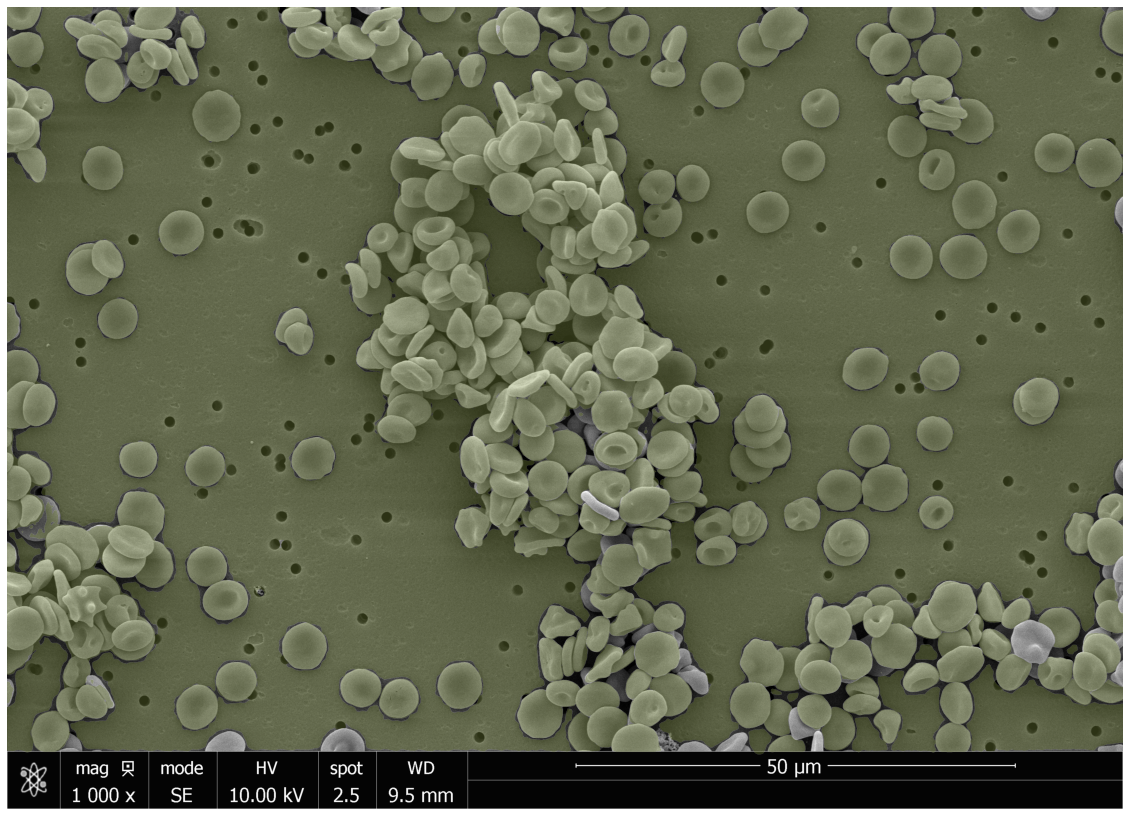

In [30]:
def show_masks(masks, mask_areas, mask_area_threshold):
    if len(masks) == 0:
        return
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((masks[0].shape[0], masks[0].shape[1], 4))
    img[:,:,3] = 0
    displayed = 0
    color_mask = np.concatenate([np.random.random(3), [0.35]])
    for mask, mask_area in zip(masks, mask_areas):
        if mask_area > mask_area_threshold: continue
        img[mask] = color_mask
        displayed += 1
    ax.imshow(img)

    print('showing {} masks out of {}'.format(displayed, len(masks)))

def show_image_with_masks(image, masks, mask_areas):
    plt.figure(figsize=(20,20))
    plt.imshow(image)
    show_masks(masks, mask_areas, np.percentile(mask_areas, 99))
    plt.axis('off')
    plt.show() 

show_image_with_masks(image_data.image, predicted_masks, mask_areas)